# CISSM.
El archivo CSV contiene información sobre incidentes de ciberataques, con detalles sobre la fecha del evento, los actores involucrados, el tipo de evento, la organización afectada, el tipo de industria, la fuente del evento, el país, el motivo y el tipo de ataque.

## Importación de librerías.

In [1]:
# === Librerías estándar de Python ===
import os
import numpy as np

# === Librerías de análisis de datos y visualización ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Librerías de preprocesamiento de datos ===
from sklearn.preprocessing import OrdinalEncoder
from urllib.parse import urlparse

# === Librerías para aprendizaje supervisado ===
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# === Librerías para métricas de evaluación ===
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_score,
    recall_score,
)

# === Librerías para aprendizaje no supervisado ===
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# === Librerías para balanceo de datos ===
from imblearn.over_sampling import RandomOverSampler

# === Librerías adicionales ===
from tabulate import tabulate

# === Configuración de colores ===
denexus_colors = ['#1B2D40', '#577596', '#C7262B', '#F85C37', '#FF8250', '#4A4A4A']
denexus_palette = sns.light_palette("#1B2D40", n_colors=100, as_cmap=True)

## Importación e información de dataframes

In [2]:
df = pd.read_csv('./data/CISSM.csv')
df

,event_description,event_date,actor,actor_type,event_type,organization,event_subtype,motive,event_source,country,industry,industry_code,id,dnx_id,date_uploaded
0,"Innovery, an Italian company delivering IT ser...",2023-09-30,Undetermined,Criminal,Exploitive,Innovery,Exploitation of Application Server,Financial,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,f5c2ebc02807a6b3,inc_cis_13422,2024-04-01
1,The ALPHV/BlackCat ransomware gang adds the ho...,2023-09-30,ALPHV,Criminal,Mixed,Motel One,"Data Attack,Undetermined",Financial,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,0b7a20f4161d89b2,inc_cis_13421,2024-04-01
2,The pro-Russian collective NoName057(16) takes...,2023-09-29,NoName057(16),Hacktivist,Disruptive,Multiple organizations in Italy,External Denial of Service,Protest,https://www.redhotcyber.com/post/si-ricomincia...,ITA,Public Administration,92.0,2e37d07ef6ef3cb6,inc_cis_13420,2024-04-01
3,API Financial Solutions files a notice of data...,2023-09-29,Undetermined,Criminal,Exploitive,API Financial Solutions,Undetermined,Financial,https://www.jdsupra.com/legalnews/api-financia...,USA,Finance and Insurance,52.0,f8029e6b6169de1f,inc_cis_13419,2024-04-01
4,"McLaren HealthCare, confirms to be dealing wit...",2023-09-29,ALPHV,Criminal,Mixed,McLaren HealthCare,"Data Attack,Undetermined",Financial,https://therecord.media/mclaren-healthcare-ran...,USA,Health Care and Social Assistance,62.0,1ed93f0579b9056c,inc_cis_13418,2024-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,Erlanger Health is also affected by the MOVEit...,2023-09-27,Qilin,Criminal,Mixed,Cardiovascular Consultants,Exploitation of Application Server,Financial,https://www.databreaches.net/cardiovascular-co...,USA,Health Care and Social Assistance,62.0,c823006f6c70313c,inc_cis_4,2024-04-01
13419,The European Telecommunications Standards Inst...,2023-09-27,cl0p,Criminal,Exploitive,Erlanger Health,Exploitation of Application Server,Financial,https://www.hipaajournal.com/oak-valley-hospit...,USA,Health Care and Social Assistance,62.0,c886a43fe79a0a7b,inc_cis_3,2024-04-01
13420,Lost Trust Team adds GI Medical Services in Ne...,2023-09-27,Undetermined,Criminal,Exploitive,European Telecommunications Standards Institut...,Exploitation of Application Server,Undetermined,https://therecord.media/etsi-telecommunication...,FRA,Information,51.0,bb17aacdf2e20d25,inc_cis_2,2024-04-01
13421,"UK charities including Shelter, the RSPCA, the...",2023-09-27,Lost Trust,Criminal,Exploitive,GI Medical Services,Undetermined,Financial,https://www.databreaches.net/and-yet-more-vict...,USA,Health Care and Social Assistance,62.0,bac11292d79231f0,inc_cis_1,2024-04-01


Debemos de tomar la columna ID como índice.

In [3]:
df.set_index('id', inplace=True)

In [4]:
df.describe()

,event_description,event_date,actor,actor_type,event_type,organization,event_subtype,motive,event_source,country,industry,industry_code,dnx_id,date_uploaded
count,13423,13423,13423,13423,13423,13423,13423,13423,13423,13423,13423,13423,13423,13423
unique,11646,3126,1163,7,5,12202,95,13,10724,164,22,26,13423,1
top,Vice Society encrypts network and threatens to...,2017-06-27,Undetermined,Criminal,Exploitive,Undetermined,Exploitation of Application Server,Financial,https://stniiomyjliimcgkvdszvgen3eaaoz55hreqqx...,USA,Public Administration,92.0,inc_cis_13422,2024-04-01
freq,97,78,7639,10181,6676,56,4314,7533,73,6459,2518,2518,1,13423


In [5]:
df.shape

(13423, 14)

In [6]:
df.dtypes

event_description    object
event_date           object
actor                object
actor_type           object
event_type           object
organization         object
event_subtype        object
motive               object
event_source         object
country              object
industry             object
industry_code        object
dnx_id               object
date_uploaded        object
dtype: object

In [7]:
df['industry_code'] = pd.to_numeric(df['industry_code'], errors='coerce')

In [8]:
df.columns

Index(['event_description', 'event_date', 'actor', 'actor_type', 'event_type',
       'organization', 'event_subtype', 'motive', 'event_source', 'country',
       'industry', 'industry_code', 'dnx_id', 'date_uploaded'],
      dtype='object')

A continuación, se incluye una breve explicación sobre la información que aporta cada columna.
1. **ID**: Un identificador único para cada incidente de ciberataque.
2. **Event Description**: Descripción detallada del incidente, explicando qué ocurrió durante el ataque.
3. **Event Date**: Fecha en la que ocurrió el evento o ataque.
4. **Actor**: La entidad o grupo responsable del ataque.
5. **Actor Type**: El tipo de actor responsable del ataque, como "Criminal" o "Estado".
6. **Event Type**: Tipo de ataque realizado, como "Exploitive" o "Data Attack".
7. **Organization**: La organización o empresa que fue el objetivo del ataque.
8. **Event Subtype**: Subtipo del evento que describe más específicamente el ataque.
9. **Motive**: Razón o motivo detrás del ataque, por ejemplo, "Financial" si el objetivo es económico.
10. **Event Source**: Fuente de información sobre el evento, generalmente un enlace a un artículo o informe.
11. **Country**: País donde ocurrió el ataque o donde está ubicada la organización objetivo.
12. **Industry**: Sector o industria al que pertenece la organización atacada.
13. **Industry Code**: Código numérico que representa el sector o industria de la organización.
14. **DNX ID**: Un identificador adicional del incidente dentro del sistema de la base de datos.
15. **Date Uploaded**: La fecha en que la información sobre el incidente fue subida al sistema o base de datos.

In [9]:
df.head(3)

,event_description,event_date,actor,actor_type,event_type,organization,event_subtype,motive,event_source,country,industry,industry_code,dnx_id,date_uploaded
id,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",2023-09-30,Undetermined,Criminal,Exploitive,Innovery,Exploitation of Application Server,Financial,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,inc_cis_13422,2024-04-01
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,2023-09-30,ALPHV,Criminal,Mixed,Motel One,"Data Attack,Undetermined",Financial,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,inc_cis_13421,2024-04-01
2e37d07ef6ef3cb6,The pro-Russian collective NoName057(16) takes...,2023-09-29,NoName057(16),Hacktivist,Disruptive,Multiple organizations in Italy,External Denial of Service,Protest,https://www.redhotcyber.com/post/si-ricomincia...,ITA,Public Administration,92.0,inc_cis_13420,2024-04-01


In [10]:
df['event_date'] = pd.to_datetime(df['event_date'])

In [11]:
df['year'] = df['event_date'].dt.year
df['month'] = df['event_date'].dt.month
df['day'] = df['event_date'].dt.day

In [12]:
df.drop('event_date', axis = 1, inplace = True)

In [13]:
df.head(2)

,event_description,actor,actor_type,event_type,organization,event_subtype,motive,event_source,country,industry,industry_code,dnx_id,date_uploaded,year,month,day
id,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Criminal,Exploitive,Innovery,Exploitation of Application Server,Financial,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,inc_cis_13422,2024-04-01,2023,9,30
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Criminal,Mixed,Motel One,"Data Attack,Undetermined",Financial,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,inc_cis_13421,2024-04-01,2023,9,30


## Limpieza de datos.
A simple vista, podemos detectar algunas columnas que no aportarán información para la identificación de patrones de ciberataques. La fecha en que la información fue subida al sistema no es relevante para el análisis de los incidentes en sí, ya que no afecta la naturaleza o el impacto del ataque, **Date Uploaded**. Finalmente, la columna **Industry** puede parecer importante, pero se elimina ya que existe otra en la que está representada por el código de la industria.

In [14]:
df.drop(['date_uploaded'], axis = 1, inplace = True)

### Manejo de filas duplicadas.
En caso de haber filas duplicadas, deberemos de eliminar estas para que no afecten al análisis posterior.

In [15]:
df.duplicated().sum() # Columnas duplicadas

0

In [16]:
df.drop_duplicates(inplace = True)

In [17]:
df.shape

(13423, 15)

### Manejo de filas nulas.

In [18]:
df.isnull().sum() # Valores nulos

event_description     0
actor                 0
actor_type            0
event_type            0
organization          0
event_subtype         0
motive                0
event_source          0
country               0
industry              0
industry_code        22
dnx_id                0
year                  0
month                 0
day                   0
dtype: int64

In [19]:
df.dropna(inplace = True)

Al examinar detenidamente el DataFrame, notamos que hay algunas columnas que no están marcadas como valores nulos, pero que contienen el texto `'[]'`, lo que indica que son valores vacíos. Es necesario revisar estas filas para determinar cómo manejarlas.

Después de esta revisión, concluimos que las filas afectadas son bastante pocas en comparación con el total de filas en el DataFrame original. Por lo tanto, la mejor opción sería eliminarlas.

In [20]:
(df == '[]').sum()

event_description     3
actor                 0
actor_type            0
event_type            0
organization          0
event_subtype        21
motive                1
event_source          4
country               8
industry              0
industry_code         0
dnx_id                0
year                  0
month                 0
day                   0
dtype: int64

In [21]:
df.drop(df[(df == '[]').any(axis=1)].index, inplace=True)

In [22]:
df.shape

(13364, 15)

### Selección de variables categóricas y continuas.
Para realizar correctamente un ánalisis de datos debemos de distinguir entre las variables categóricas, variables que representan diferentes categorías o grupos, y continuas, variables que pueden tomar cualquier valor dentro de un rango determinado.

In [23]:
v_continuas = []
v_categoricas = []
for i in df.columns:
    if df[i].nunique() > 25 or df[i].dtypes in ['float64', 'int64']:
        v_continuas.append(i)
    else:
        v_categoricas.append(i)

print('Variables continuas: {}'.format(', '.join(v_continuas)))
print('Variables categóricas: {}'.format(', '.join(v_categoricas)))

Variables continuas: event_description, actor, organization, event_subtype, event_source, country, industry_code, dnx_id, year, month, day
Variables categóricas: actor_type, event_type, motive, industry


#### Tratamiento de variables categóricas.
Para el posterior modelo de clasificación, necesitamos codificar nuestras variables. Para ello, realizaremos una codificación ordinal que consiste en asignar valores enteros a las categorias basándose en su posición o jerarquía en los datos.

In [24]:
df[v_categoricas].head(3)

,actor_type,event_type,motive,industry
id,,,,
f5c2ebc02807a6b3,Criminal,Exploitive,Financial,"Professional, Scientific, and Technical Services"
0b7a20f4161d89b2,Criminal,Mixed,Financial,Accommodation and Food Services
2e37d07ef6ef3cb6,Hacktivist,Disruptive,Protest,Public Administration


In [25]:
df[v_categoricas].nunique()

actor_type     7
event_type     5
motive        11
industry      21
dtype: int64

##### **Industry.**
Esta columna ya viene codificada a través de **Industry Code**. Guardámos la columna para saber a que corresponde cada una.

In [26]:
df['industry'].nunique()

21

In [27]:
df['industry_code'].nunique()

25

In [28]:
industry_to_code = df.drop_duplicates(subset=['industry', 'industry_code']).set_index('industry')['industry_code'].to_dict()

In [29]:
industry_to_code

{'Professional, Scientific, and Technical Services': 54.0,
 'Accommodation and Food Services': 72.0,
 'Public Administration': 92.0,
 'Finance and Insurance': 52.0,
 'Health Care and Social Assistance': 62.0,
 'Information': 51.0,
 'Administrative and Support and Waste Management and Remediation Services': 56.0,
 'Manufacturing': 32.0,
 'Construction': 23.0,
 'Retail Trade': 45.0,
 'Educational Services': 61.0,
 'Wholesale Trade': 42.0,
 'Real Estate and Rental and Leasing': 53.0,
 'Transportation and Warehousing': 49.0,
 'Other Services (except Public Administration)': 81.0,
 'Arts, Entertainment, and Recreation': 71.0,
 'Utilities': 22.0,
 'Undetermined': 99.0,
 'Agriculture, Forestry, Fishing and Hunting': 11.0,
 'Mining, Quarrying, and Oil and Gas Extraction': 21.0,
 'Management of Companies and Enterprises': 55.0}

##### **Event Type.**

In [30]:
df['event_type'].unique()

array(['Exploitive', 'Mixed', 'Disruptive', 'Undetermined',
       'Exploitation of Application Server'], dtype=object)

Los valores **Exploitive** y **Exploitation of Application Server** están relacionados con la explotación de vulnerabilidades, ya sea de manera general o específica (como en un servidor de aplicaciones). Por ello los juntaremos en la misma categoria.

In [31]:
df['event_type'].replace('Exploitation of Application Server', 'Exploitive', inplace=True)

In [32]:
df['event_type'].unique()

array(['Exploitive', 'Mixed', 'Disruptive', 'Undetermined'], dtype=object)

Cuando trabajamos con variables categóricas, como en este caso con la columna 'event_type' que tiene valores como **Exploitive**, **Disruptive**, **Mixed** y **Undetermined**, se suele utilizar la técnica de **One-hot encoder** para convertir estas categorías en variables binarias que un modelo de Machine Learning pueda entender. El objetivo es crear una columna para cada categoría con valores 0 o 1, indicando si un evento pertenece a esa categoría o no.

El valor **Mixed** es especial porque representa una combinación de dos categorías: **Exploitive** y **Disruptive**. Esto significa que cuando un evento está clasificado como **Mixed**, en realidad debe ser tratado como si fuera tanto **Exploitive** como **Disruptive**. Añadiendo un 1 en cada columna de estos.

In [33]:
dummies = pd.get_dummies(df['event_type'])
dummies['Exploitive'] = dummies['Exploitive'] | dummies['Mixed']
dummies['Disruptive'] = dummies['Disruptive'] | dummies['Mixed']

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.

In [34]:
dummies.drop(['Mixed'], axis=1, inplace=True)
dummies.columns = ['event_type_' + col for col in dummies.columns]

In [35]:
idx = df.columns.get_loc('event_type') + 1

df_before = df.iloc[:, :idx]
df_after = df.iloc[:, idx:]

df = pd.concat([df_before, dummies, df_after], axis=1)

In [36]:
df.head(2)

,event_description,actor,actor_type,event_type,event_type_Disruptive,event_type_Exploitive,event_type_Undetermined,organization,event_subtype,motive,event_source,country,industry,industry_code,dnx_id,year,month,day
id,,,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Criminal,Exploitive,0,1,0,Innovery,Exploitation of Application Server,Financial,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,inc_cis_13422,2023,9,30
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Criminal,Mixed,1,1,0,Motel One,"Data Attack,Undetermined",Financial,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,inc_cis_13421,2023,9,30


##### **Motive**

In [37]:
df['motive'].unique()

array(['Financial', 'Protest', 'Undetermined', 'Political-Espionage',
       'Sabotage', 'Espionage', 'Espionage-Political', 'Sabatoge',
       'Personal Attack', 'Protest,Financial', 'Industrial-Espionage'],
      dtype=object)

Debemos de arreglar fallos de escritura primero. En nuestro conjunto de datos, encontramos entradas como **Sabatoge**, que son errores de escritura y deben corregirse a **Sabotage**. Estas correcciones aseguran que todos los datos sean consistentes y que no haya duplicados causados por errores de escritura.

In [38]:
df['motive'] = df['motive'].str.replace('Espionage-Political', 'Political-Espionage')
df['motive'] = df['motive'].str.replace('Sabatoge', 'Sabotage')

Es importante agrupar categorías que representan la misma amenaza. Por ejemplo, las categorías **Industrial-Espionage** y **Political-Espionage** pueden ser agrupadas bajo una sola categoría: **Espionage**. Esta agrupación ayuda a simplificar el análisis, permitiendo que se obtengan conclusiones más claras y significativas.

In [39]:
motive_mapping = {
    'Political-Espionage': 'Espionage',
    'Industrial-Espionage': 'Espionage',
}

# Aplicamos la agrupación
df['motive'] = df['motive'].replace(motive_mapping)

In [40]:
df['motive'].unique()

array(['Financial', 'Protest', 'Undetermined', 'Espionage', 'Sabotage',
       'Personal Attack', 'Protest,Financial'], dtype=object)

En el proceso de limpieza de datos, es posible que se detecten casos donde una fila contenga múltiples categorías que deberían ser exclusivas. En nuestro conjunto de datos, hemos encontrado un caso donde una entrada presenta simultáneamente las categorías **Protest** y **Financial**. Sin embargo, dado que esta situación ocurre solo en una fila de aproximadamente 13000 registros, podemos prescindir de este caso sin afectar significativamente el análisis general.

In [41]:
df.drop(df[df['motive'] == 'Protest,Financial'].index, inplace=True) # solo es una fila, por no hacer get_dummies.

In [42]:
df['motive'].unique()

array(['Financial', 'Protest', 'Undetermined', 'Espionage', 'Sabotage',
       'Personal Attack'], dtype=object)

In [43]:
encoder = OrdinalEncoder()
df.insert(df.columns.get_loc('motive') + 1, 'motive_code', encoder.fit_transform(df[['motive']]))
df.head(2)

,event_description,actor,actor_type,event_type,event_type_Disruptive,event_type_Exploitive,event_type_Undetermined,organization,event_subtype,motive,motive_code,event_source,country,industry,industry_code,dnx_id,year,month,day
id,,,,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Criminal,Exploitive,0,1,0,Innovery,Exploitation of Application Server,Financial,1.0,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,inc_cis_13422,2023,9,30
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Criminal,Mixed,1,1,0,Motel One,"Data Attack,Undetermined",Financial,1.0,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,inc_cis_13421,2023,9,30


##### **Actor Type.**
Debemos examinar cuidadosamente esta columna para determinar si es posible realizar la codificación ordinal. Como se observa, hay un valor que aparece como `Undeterminated` y otro valor de `Criminal` que está mal escrito en una de las entradas.

In [44]:
df['actor_type'] = df['actor_type'].str.replace('Criminal', 'Criminal', regex=True)
df['actor_type'].unique()

array(['Criminal', 'Hacktivist', 'Nation-State', 'Undetermined',
       'Hobbyist', 'Crimimal', 'Terrorist'], dtype=object)

In [45]:
df['actor_type'] = df['actor_type'].str.replace('Crimimal', 'Criminal', regex=True)

In [46]:
df['actor_type'].unique()

array(['Criminal', 'Hacktivist', 'Nation-State', 'Undetermined',
       'Hobbyist', 'Terrorist'], dtype=object)

In [47]:
mapping_actors = {'Criminal': ['Criminal', 'Nation-State', 'Terrorist'],
           'Hacktivist': ['Hacktivist', 'Hobbyist', 'Undetermined']}

In [48]:
def map_actors(title):
    for category, titles in mapping_actors.items():
        if title in titles:
            return category
    return None

In [49]:
df['actor_type'] = df['actor_type'].apply(map_actors)

In [50]:
encoder = OrdinalEncoder()
df['actor_type_code'] = encoder.fit_transform(df[['actor_type']])

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.

In [51]:
columns = df.columns.tolist()
index = columns.index('actor_type')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [52]:
df.head(3)

,event_description,actor,actor_type,actor_type_code,event_type,event_type_Disruptive,event_type_Exploitive,event_type_Undetermined,organization,event_subtype,motive,motive_code,event_source,country,industry,industry_code,dnx_id,year,month,day
id,,,,,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Criminal,0.0,Exploitive,0,1,0,Innovery,Exploitation of Application Server,Financial,1.0,https://www.redhotcyber.com/post/attacco-infor...,ITA,"Professional, Scientific, and Technical Services",54.0,inc_cis_13422,2023,9,30
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Criminal,0.0,Mixed,1,1,0,Motel One,"Data Attack,Undetermined",Financial,1.0,https://securityaffairs.com/151732/cyber-crime...,DEU,Accommodation and Food Services,72.0,inc_cis_13421,2023,9,30
2e37d07ef6ef3cb6,The pro-Russian collective NoName057(16) takes...,NoName057(16),Hacktivist,1.0,Disruptive,1,0,0,Multiple organizations in Italy,External Denial of Service,Protest,3.0,https://www.redhotcyber.com/post/si-ricomincia...,ITA,Public Administration,92.0,inc_cis_13420,2023,9,29


#### Tratamiento de variables continuas.
Para el modelo de clasificación debemos de pasar todas las columnas a tipo `int`. Por ello, debemos de ver si realizar como en el caso anterior una codificación ordinal o agruparlos.

In [53]:
df[v_continuas].head(2)

,event_description,actor,organization,event_subtype,event_source,country,industry_code,dnx_id,year,month,day
id,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Innovery,Exploitation of Application Server,https://www.redhotcyber.com/post/attacco-infor...,ITA,54.0,inc_cis_13422,2023,9,30
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Motel One,"Data Attack,Undetermined",https://securityaffairs.com/151732/cyber-crime...,DEU,72.0,inc_cis_13421,2023,9,30


In [54]:
v_categoricas_cont = list(df[v_continuas].dtypes[df[v_continuas].dtypes == 'object'].index)
v_categoricas_cont.remove('dnx_id')

In [55]:
df[v_categoricas_cont].nunique()

event_description    11591
actor                 1161
organization         12150
event_subtype           93
event_source         10687
country                163
dtype: int64

##### **Event Subtype.**

In [56]:
df['event_subtype'].unique()[:10]

array(['Exploitation of Application Server', 'Data Attack,Undetermined',
       'External Denial of Service', 'Undetermined',
       'Exploitation of Application Server,Data Attack',
       'Exploitation of End User', 'Exploitation of Infrastructure',
       'Message Manipulation', 'Data Attack,Exploitation of End User',
       'Exploitation of End Host'], dtype=object)

**Corrección de escritura.**

In [57]:
df['event_subtype'] = df['event_subtype'].str.replace('Exploittation of Application Server', 'Exploitation of Application Server')

##### **Country.**
Para realizar una evaluación más efectiva de los países en nuestros datos, es conveniente agruparlos por continentes. Esto es especialmente relevante porque en otros archivos CSV hay registros de ataques provenientes de diferentes países, distribuidos en distintos continentes.

Para facilitar este análisis, procederemos a crear seis nuevas columnas en nuestro conjunto de datos, cada una representando un continente específico. Estas columnas indicarán con un valor de 1 si el país pertenece al continente correspondiente y 0 si no es así, es decir, mediante una asignación de valores binarios.

In [58]:
df['country'].unique()

array(['ITA', 'DEU', 'USA', 'RUS', 'CAN', 'GBR', 'FRA', 'JPN', 'UKR',
       'PHL', 'HKG', 'SGP', 'BMU', 'NZL', 'CHN', '999', 'ISR', 'BRA',
       'KWT', 'THA', 'IND', 'COL', 'LKA', 'ESP', 'AUS', 'NLD', 'TUR',
       'TWN', 'MEX', 'MAR', 'CZE', 'KOR', 'IRN', 'POL', 'BEL', 'DNK',
       'ZAF', 'CHE', 'SRB', 'SLV', 'LTU', 'ECU', 'ARG', 'IDN', 'VNM',
       'PRT', 'PAK', 'NGA', 'KEN', 'NOR', 'EGY', 'MYS', 'IRL', 'SWE',
       'FIN', 'MLT', 'BLR', 'TTO', 'MLI', 'JAM', 'EST', 'GRC', 'CHL',
       'CYM', 'HRV', 'SYC', 'VEN', 'GTM', 'CYP', 'PAN', 'CRI', 'VCT',
       'PRI', 'PER', 'DOM', 'BHR', 'TON', 'URY', 'SVK', 'LVA', 'CUB',
       'MDA', 'ARE', 'AUT', 'BRB', 'ROU', 'VAT', 'MDV', 'GLP', 'BES',
       'TGO', 'SAU', 'VUT', 'BGR', 'HUN', 'BHS', 'MMR', 'PRY', 'KAZ',
       'GHA', 'BIH', 'ALB', 'MNE', 'BOL', 'ASM', 'KIR', 'LUX', 'BGD',
       'GRL', 'ZMB', 'JOR', 'NRU', 'GIB', 'GUF', 'LBN', 'QAT', 'SVN',
       'PRK', 'AND', 'AGO', 'PNG', 'AFG', 'GEO', 'FJI', 'OMN', 'MNG',
       'NPL', 'CPV',

In [59]:
continent_mapping = {
    'Europe': ['ITA', 'DEU', 'GBR', 'FRA', 'UKR', 'ESP', 'NLD', 'POL', 'BEL', 'DNK',
               'CHE', 'SRB', 'LTU', 'MLT', 'GRC', 'CZE', 'HRV', 'HUN', 'AUT', 'SVK',
               'BLR', 'BGR', 'GIB', 'MDA', 'PRT', 'SVN', 'AND', 'LVA', 'CUB', 'KIR', 
               'RUS', 'NOR', 'SWE', 'FIN', 'EST', 'IRL', 'CYP', 'TUR', 'ROU', 'VAT',
                'MDV', 'BIH', 'ALB', 'MNE', 'LUX', 'ARM', 'IMN', 'LIE', 'MCO', 'AZE',
                'ISL', 'MKD'],
    'North America': ['USA', 'CAN', 'BMU', 'MEX', 'NIC', 'CRI', 'SLV', 'GTM', 
                      'PRI', 'TTO', 'JAM', 'BHS', 'BLZ', 'CYM', 'BRB', 'GLP',
                      'GRL'],
    'South America': ['BRA', 'ARG', 'COL', 'PER', 'VEN', 'CHL', 'URY', 'PAR', 
                      'BOL', 'ECU', 'PAN', 'VCT', 'DOM', 'BES', 'PRY', 'GUF',],
    'Asia': ['JPN', 'CHN', 'KWT', 'THA', 'IND', 'PHL', 'HKG', 'SGP', 'IDN', 
             'VNM', 'IRN', 'KOR', 'PAK', 'ISR', 'TWN', 'BGD', 'AFG', 'KHM', 
             'LAO', 'OMN', 'QAT', 'JOR', 'IRQ', 'MNG', 'UZB', 'TKM', 'YEM', 
             'MDA', 'GEO', 'FJI', 'LKA', 'TJK', 'MYS', 'BHR', 'ARE', 'SAU',
              'MMR', 'KAZ', 'LBN', 'PRK', 'NPL', 'SYR', 'LBY', 'PSE'],
    'Africa': ['ZAF', 'EGY', 'KEN', 'NGA', 'GHA', 'ETH', 'ZMB', 'UGA', 
               'DZA', 'TGO', 'MAR', 'SDN', 'SLE', 'RWA', 'AGO', 'MLI', 
               'TUN', 'ZWE', 'NAM', 'LSO', 'MZW', 'SYC', 'CPV', 'GAB',
               'MWI', 'TZA', 'SEN'],
    'Australia': ['NZL', 'AUS', 'TON', 'PNG', 'NRU', 'FJI', 'PLW', 'KIR', 'VUT', 'ASM', 'GUM']
}

In [60]:
def assign_continent(country):
    for continent, countries in continent_mapping.items():
        if country in countries:
            return continent
    return None  # Si el país no está en la lista, retornar None

In [61]:
df['country'].nunique()

163

In [62]:
df['continent'] = df['country'].map(assign_continent)

In [63]:
df['continent'].unique()

array(['Europe', 'North America', 'Asia', 'Australia', None,
       'South America', 'Africa'], dtype=object)

In [64]:
countries_with_no_continent = df[df['continent'].isnull()]['country'].unique()

# Mostrar la lista de países con 'continent' como None
print("Lista de países con 'continent' como None:")
print(countries_with_no_continent)

Lista de países con 'continent' como None:
['999' 'ATA']


In [65]:
df.dropna(subset=['continent'], inplace=True)

In [66]:
df['continent'] = df['country'].apply(assign_continent)
df_continentes = pd.get_dummies(df['continent'])
df = pd.concat([df, df_continentes], axis=1)

In [67]:
df.drop(['country', 'continent'], axis = 1, inplace = True)

In [68]:
df.head(2)

,event_description,actor,actor_type,actor_type_code,event_type,event_type_Disruptive,event_type_Exploitive,event_type_Undetermined,organization,event_subtype,...,dnx_id,year,month,day,Africa,Asia,Australia,Europe,North America,South America
id,,,,,,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Criminal,0.0,Exploitive,0,1,0,Innovery,Exploitation of Application Server,...,inc_cis_13422,2023,9,30,0,0,0,1,0,0
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Criminal,0.0,Mixed,1,1,0,Motel One,"Data Attack,Undetermined",...,inc_cis_13421,2023,9,30,0,0,0,1,0,0


##### **Event Source.**
Deberemos de extraer el nombre del dominio de la URL.

In [69]:
df['event_source'] = df['event_source'].apply(lambda x: urlparse(str(x)).netloc)

In [70]:
df.head(2)

,event_description,actor,actor_type,actor_type_code,event_type,event_type_Disruptive,event_type_Exploitive,event_type_Undetermined,organization,event_subtype,...,dnx_id,year,month,day,Africa,Asia,Australia,Europe,North America,South America
id,,,,,,,,,,,,,,,,,,,,,
f5c2ebc02807a6b3,"Innovery, an Italian company delivering IT ser...",Undetermined,Criminal,0.0,Exploitive,0,1,0,Innovery,Exploitation of Application Server,...,inc_cis_13422,2023,9,30,0,0,0,1,0,0
0b7a20f4161d89b2,The ALPHV/BlackCat ransomware gang adds the ho...,ALPHV,Criminal,0.0,Mixed,1,1,0,Motel One,"Data Attack,Undetermined",...,inc_cis_13421,2023,9,30,0,0,0,1,0,0


In [71]:
df_cleaned = df.copy()

In [72]:
df.to_csv('./data/CISSM_cleaned.csv', index=False)

## Modelos de clasificación.
En este análisis desarrollaremos modelos de clasificación para identificar patrones y predecir ciberataques. Utilizaremos **Actor Type Code** como variable objetivo, ya que representa diferentes tipos de actores detrás de los ataques. Realizaremos modelos supervisados. Para los modelos supervisados, realizaremos evaluación cruzada para medir su generalización. Y al ser una columna de tipo binaria, se realizará la curva ROC.

In [73]:
df_1 = df.drop(list(df.select_dtypes(include=['object']).columns), axis = 1)

In [74]:
df_1.dtypes

actor_type_code            float64
event_type_Disruptive        uint8
event_type_Exploitive        uint8
event_type_Undetermined      uint8
motive_code                float64
industry_code              float64
year                         int64
month                        int64
day                          int64
Africa                       uint8
Asia                         uint8
Australia                    uint8
Europe                       uint8
North America                uint8
South America                uint8
dtype: object

### Modelos de Clasificación Supervisado.
Hemos seleccionado **Actor Type Code** como la variable objetivo porque representa diferentes tipos de actores detrás de ciberataques. Este análisis se centra en predecir el tipo de amenaza que se encuentra detrás de cada incidente, lo cual tiene un impacto directo en la planificación de estrategias de defensa. Aunque no es una variable binaria, este problema multiclase permite capturar patrones más complejos en los datos.

In [75]:
results = pd.DataFrame(columns=['Model', 'Tipo', 'Accuracy', 'Precision', 'Recall'])
results['Tipo'] = ['Binary']*2

#### Matriz de correlación.

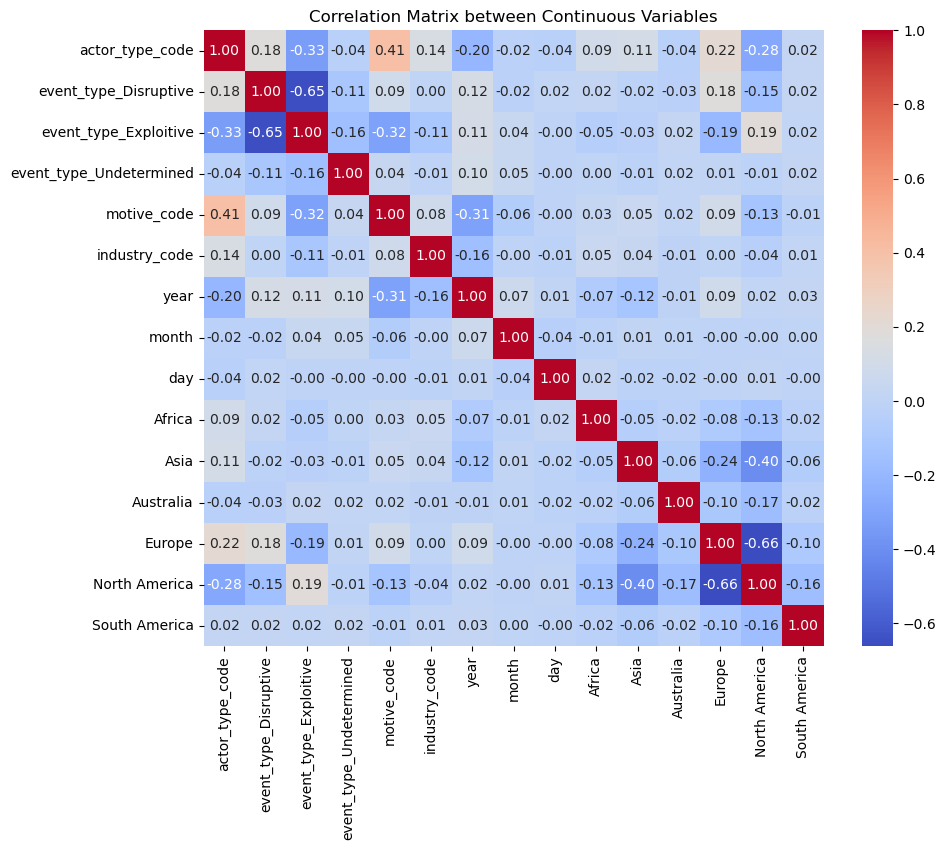

In [76]:
correlation_matrix = df_1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix between Continuous Variables')
plt.show()


#### División en Conjuntos de Entrenamiento y Prueba.

In [77]:
X = df_1.drop('actor_type_code', axis=1)
y = df_1['actor_type_code']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

In [79]:
y_train.value_counts()

0.0    8488
1.0    1927
Name: actor_type_code, dtype: int64

In [80]:
y_test.value_counts()

0.0    2114
1.0     490
Name: actor_type_code, dtype: int64

Al tener un **conjunto de entrenamiento muy desbalanceado**, lo óptimo para un correcto modelo de aprendizaje automático sería realizar un **balanceo de las clases** a través de **ROS** ya que este funciona mejor apra variables categóricas que **SMOTE**. Sin embargo, este balanceo no debe aplicarse al conjunto de prueba, ya que hacerlo alteraría la naturaleza de los datos, haciéndolos no representativos de la realidad. El **conjunto de prueba** debe reflejar fielmente la distribución de clases en el mundo real. Por lo tanto, en lugar de aplicar balanceo en el conjunto de prueba, lo que se hará será **asignar mayor importancia a las clases minoritarias** durante el entrenamiento del modelo, ajustando los pesos de las clases en el modelo. De este modo, el modelo aprenderá a prestar más atención a las clases con menos representaciones, sin comprometer la integridad del conjunto de prueba.

#### Manejo de variables desbalanceadas.
Dado el desbalance de clases en el conjunto de entrenamiento, vamos a aplicar **Random Over-Sampling (ROS)** para equilibrar las clases minoritarias. Esta técnica aumenta la representación de las clases menos frecuentes duplicando aleatoriamente sus instancias, lo que permite que el modelo aprenda de manera más equitativa.

In [81]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#### Entrenamiento y Evaluación de Modelos.
En este apartado, entrenaremos modelos de aprendizaje supervisado para predecir el tipo de actor detrás de los ciberataques.

##### **Random Forest.**
**Random Forest** es un algoritmo de aprendizaje automático basado en la creación de múltiples árboles de decisión, cuyos resultados se combinan para mejorar la precisión y evitar el sobreajuste. Es eficaz para clasificación y regresión, **manejando bien el desbalance de clases** y datos complejos.

In [82]:
rf_model = RandomForestClassifier(
                                  random_state=42,
                                  n_estimators=100,
                                  min_samples_split=5)
rf_model.fit(X_train_ros, y_train_ros)

RandomForestClassifier(min_samples_split=5, random_state=42)

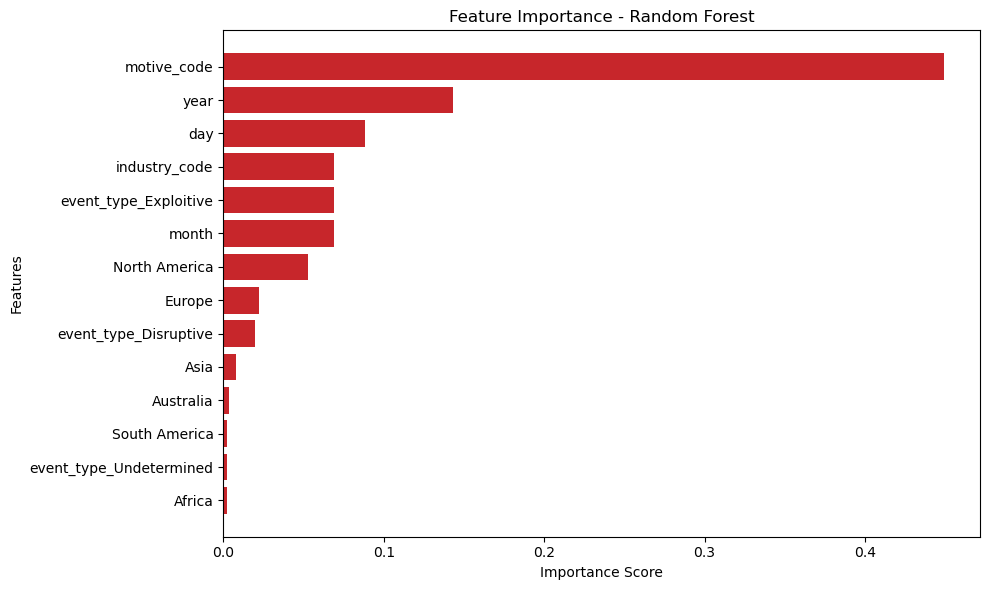

In [83]:
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center', color=denexus_colors[2])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "feature-importance_random-forest.png")
    plt.savefig(output_path)
plt.show()

In [84]:
cv_scores = cross_val_score(rf_model, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
cv_scores

array([0.97467609, 0.97349043, 0.97466863, 0.97496318, 0.96789396])

In [85]:
print("Train set score (Accuracy) =", rf_model.score(X_train_ros, y_train_ros))
print("Test set score (Accuracy) =", rf_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, rf_model.predict(X_test))

num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))

Train set score (Accuracy) = 0.9972313854853911
Test set score (Accuracy) = 0.9320276497695853
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           2015 │             99 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │             78 │            412 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      2114
         1.0       0.81      0.84      0.82       490

    accuracy                           0.93      2604
   macro avg       0.88      0.90      0.89      2604
weighted avg       0.93      0.93      0.93      2604



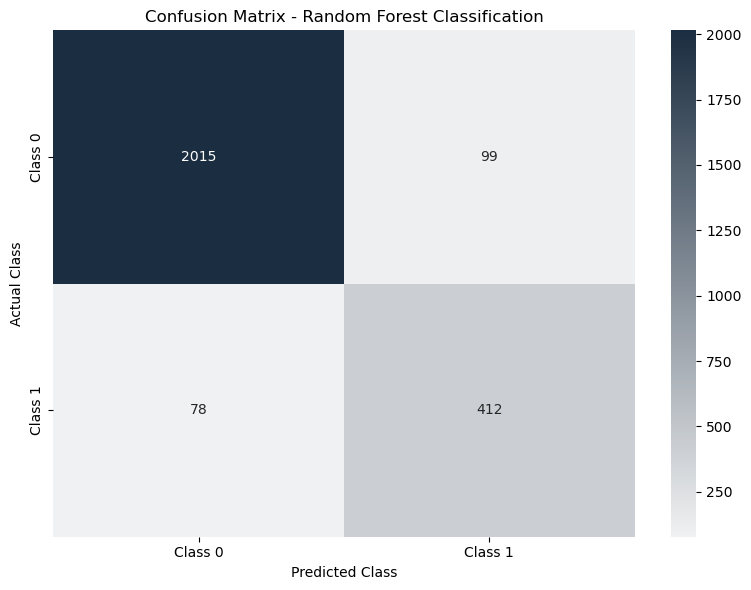

In [86]:
class_labels = [f'Class {i}' for i in range(conf_mat.shape[0])]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=denexus_palette,
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)
plt.title('Confusion Matrix - Random Forest Classification')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "confusion-matrix_random-forest.png")
    plt.savefig(output_path)
plt.show()

##### **Arbol de Decisión.**
Un Árbol de Decisión es un modelo útil para tareas de clasificación y regresión en aprendizaje automático. Es un modelo de decisión jerárquica que toma decisiones en función de las características de los datos y las distribuye en ramas, con cada nodo representando una prueba de una característica.

In [87]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_ros, y_train_ros)

DecisionTreeClassifier(random_state=42)

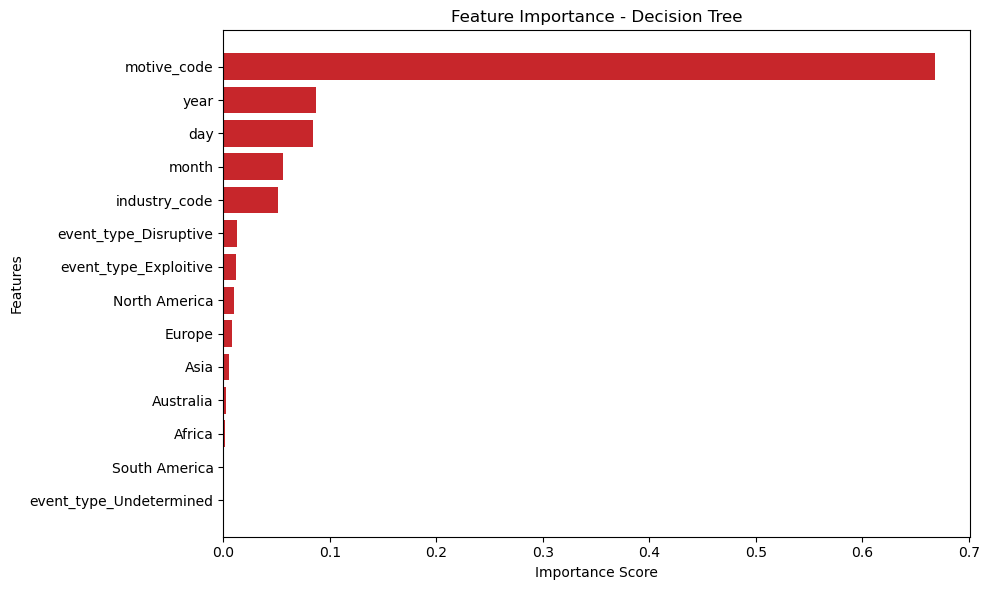

In [88]:
feature_importances = dt_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center', color=denexus_colors[2])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Decision Tree')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "feature-importance_decision-tree.png")
    plt.savefig(output_path)
plt.show()

In [89]:
cv_scores = cross_val_score(dt_model, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
cv_scores

array([0.96908127, 0.97466863, 0.97319588, 0.97437408, 0.97290133])

In [90]:
print("Train set score (Accuracy) =", dt_model.score(X_train_ros, y_train_ros))
print("Test set score (Accuracy) =", dt_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, dt_model.predict(X_test))

num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, dt_model.predict(X_test)))

Train set score (Accuracy) = 0.9990574929311969
Test set score (Accuracy) = 0.9162826420890937
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           1998 │            116 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            102 │            388 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      2114
         1.0       0.77      0.79      0.78       490

    accuracy                           0.92      2604
   macro avg       0.86      0.87      0.86      2604
weighted avg       0.92      0.92      0.92      2604



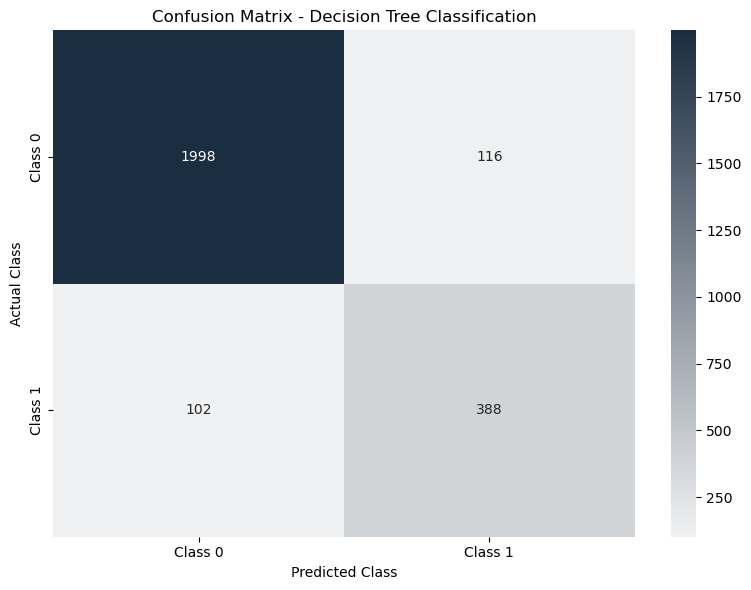

In [91]:
class_labels = [f'Class {i}' for i in range(conf_mat.shape[0])]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=denexus_palette,
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)
plt.title('Confusion Matrix - Decision Tree Classification')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "confusion-matrix_decision-tree.png")
    plt.savefig(output_path)
plt.show()

#### Curva ROC.
La **curva ROC** (*Receiver Operating Characteristic*) es una representación gráfica utilizada para evaluar el rendimiento de un modelo de clasificación binaria. Muestra la relación entre la **tasa de verdaderos positivos (TPR)** y la **tasa de falsos positivos (FPR)** a medida que varía el umbral de decisión del modelo.

Un modelo perfecto tendrá una curva que pase cerca del vértice superior izquierdo (FPR=0, TPR=1), indicando un rendimiento ideal. El área bajo la curva (**AUC** - *Area Under the Curve*) resume en un único valor qué tan bien el modelo discrimina entre las dos clases, donde un valor de 1 indica un modelo perfecto y 0.5 sugiere un rendimiento aleatorio.

In [92]:
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

In [93]:
# Calcular FPR, TPR y el AUC.
## Random Forest.
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

## Decision Tree.
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

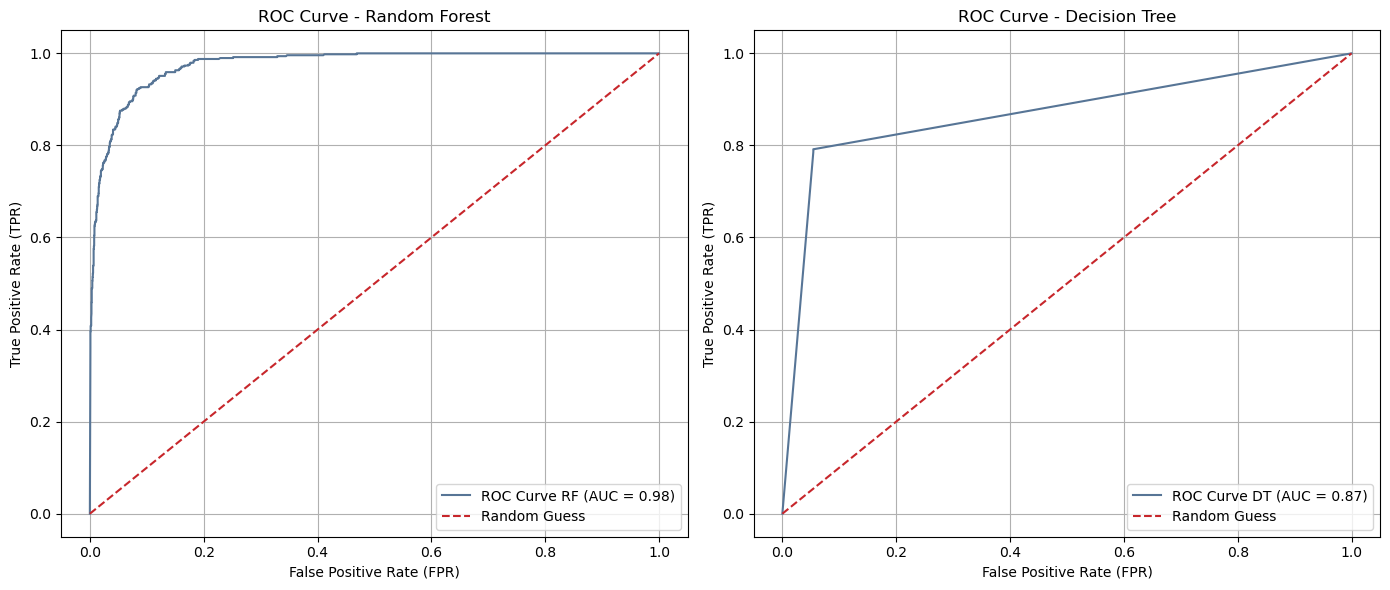

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

## Subplot para Random Forest.
axs[0].plot(fpr_rf, tpr_rf, label=f'ROC Curve RF (AUC = {roc_auc_rf:.2f})', color=denexus_colors[1])
axs[0].plot([0, 1], [0, 1], color=denexus_colors[2], linestyle='--', label='Random Guess')
axs[0].set_title('ROC Curve - Random Forest')
axs[0].set_xlabel('False Positive Rate (FPR)')
axs[0].set_ylabel('True Positive Rate (TPR)')
axs[0].legend(loc='lower right')
axs[0].grid(True)

## Subplot para Decision Tree.
axs[1].plot(fpr_dt, tpr_dt, color=denexus_colors[1], label=f'ROC Curve DT (AUC = {roc_auc_dt:.2f})')
axs[1].plot([0, 1], [0, 1], color=denexus_colors[2], linestyle='--', label='Random Guess')
axs[1].set_title('ROC Curve - Decision Tree')
axs[1].set_xlabel('False Positive Rate (FPR)')
axs[1].set_ylabel('True Positive Rate (TPR)')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "ROC-curve.png")
    plt.savefig(output_path)
plt.show()

#### Resultados.

In [95]:
rf_pred = rf_model.predict(X_test)
dt_pred = dt_model.predict(X_test)

In [96]:
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')

In [97]:
dt_precision = precision_score(y_test, dt_pred, average='weighted')
dt_recall = recall_score(y_test, dt_pred, average='weighted')

In [98]:
results['Model'] = ['RandomForest', 'DecisionTree']
results['Accuracy'] = [rf_model.score(X_test, y_test), dt_model.score(X_test, y_test)]
results['Precision'] = [rf_precision, dt_precision]
results['Recall'] = [rf_recall, dt_recall]

In [99]:
results

,Model,Tipo,Accuracy,Precision,Recall
0,RandomForest,Binary,0.932028,0.933290,0.932028
1,DecisionTree,Binary,0.916283,0.917259,0.916283


### Modelos de Clasificación No Supervisado.
Aplicamos el modelo no supervisado K-Means para agrupar los datos en los clusters indicados a través del **método Elbow**, utilizando las características del conjunto de entrenamiento. Finalmente, se genera un resumen de las medias de las características por cada cluster para su análisis.

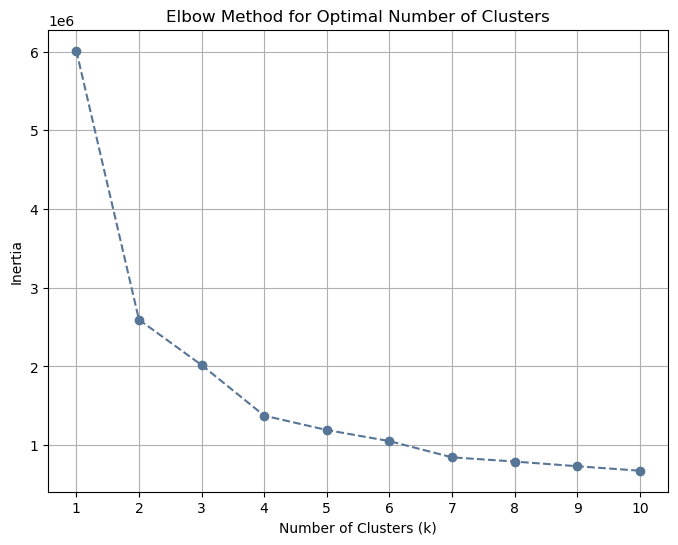

In [100]:
#Elbow method.
X_unsupervised = df_1.copy()
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_unsupervised)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', color=denexus_colors[1])
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "elbow-method-kmeans.png")
    plt.savefig(output_path)
plt.show()

In [101]:
for k, score in zip(range(1, 11), inertia):
    print(f"Number of Clusters (k={k}): Inertia = {score:.4f}")

Number of Clusters (k=1): Inertia = 6010336.7896
Number of Clusters (k=2): Inertia = 2594473.2875
Number of Clusters (k=3): Inertia = 2018370.7247
Number of Clusters (k=4): Inertia = 1375644.5427
Number of Clusters (k=5): Inertia = 1193016.7960
Number of Clusters (k=6): Inertia = 1052154.2826
Number of Clusters (k=7): Inertia = 846089.4149
Number of Clusters (k=8): Inertia = 792750.9463
Number of Clusters (k=9): Inertia = 733034.8490
Number of Clusters (k=10): Inertia = 676188.4634


In [102]:
#KMeans.
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_unsupervised)

KMeans(n_clusters=6, random_state=42)

In [103]:
X_unsupervised['Cluster'] = kmeans.predict(X_unsupervised)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Inertia for optimal_k ({optimal_k}): {kmeans.inertia_:.4f}")

Optimal number of clusters: 6
Inertia for optimal_k (6): 1052154.2826


Optimal number of clusters: 6
Inertia for optimal_k (6): 1052154.2826
Silhouette Score (Average): 0.3645


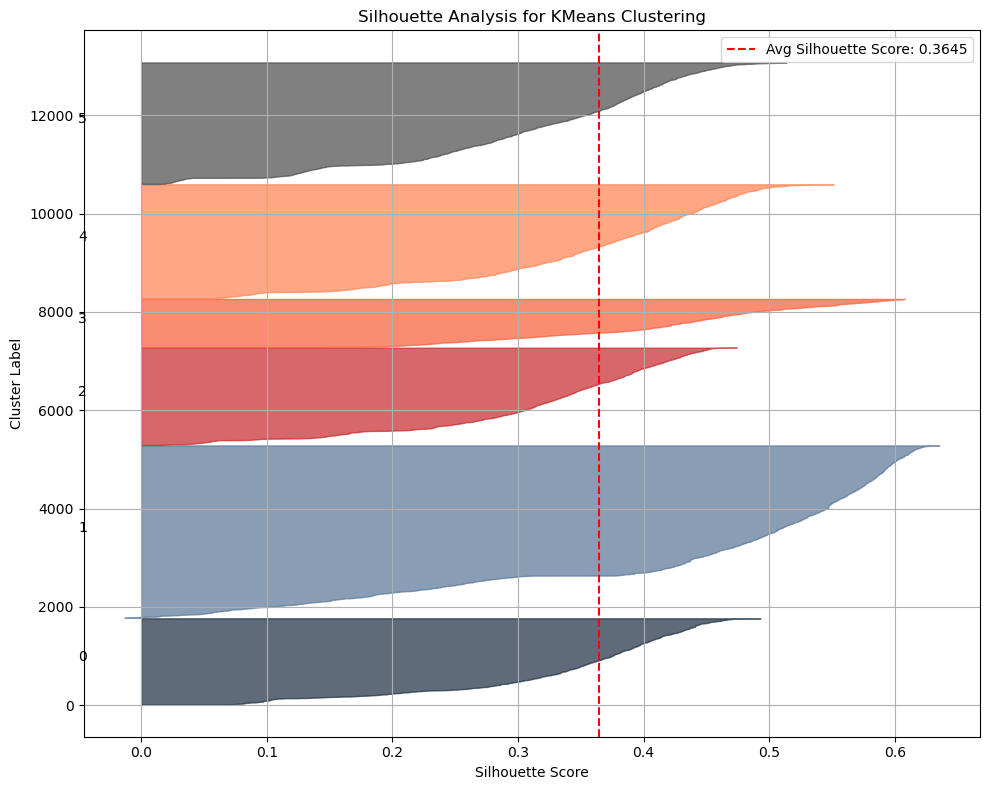

In [104]:
silhouette_avg = silhouette_score(X_unsupervised, X_unsupervised['Cluster'])
silhouette_values = silhouette_samples(X_unsupervised, X_unsupervised['Cluster'])

print(f"Optimal number of clusters: {optimal_k}")
print(f"Inertia for optimal_k ({optimal_k}): {kmeans.inertia_:.4f}")
print(f"Silhouette Score (Average): {silhouette_avg:.4f}")

# Gráfico de silueta
plt.figure(figsize=(10, 8))
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_values = silhouette_values[X_unsupervised['Cluster'] == i]
    cluster_silhouette_values.sort()
    cluster_size = len(cluster_silhouette_values)
    y_upper = y_lower + cluster_size
    
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_values,
        alpha=0.7,
        color=denexus_colors[i % len(denexus_colors)]
    )
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10  # Espacio entre clusters

plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Avg Silhouette Score: {silhouette_avg:.4f}")
plt.title("Silhouette Analysis for KMeans Clustering")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster Label")
plt.legend()
plt.grid()
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "silhouette-analysis-kmeans-cluster.png")
    plt.savefig(output_path)
plt.show()

## Gráficas generales.

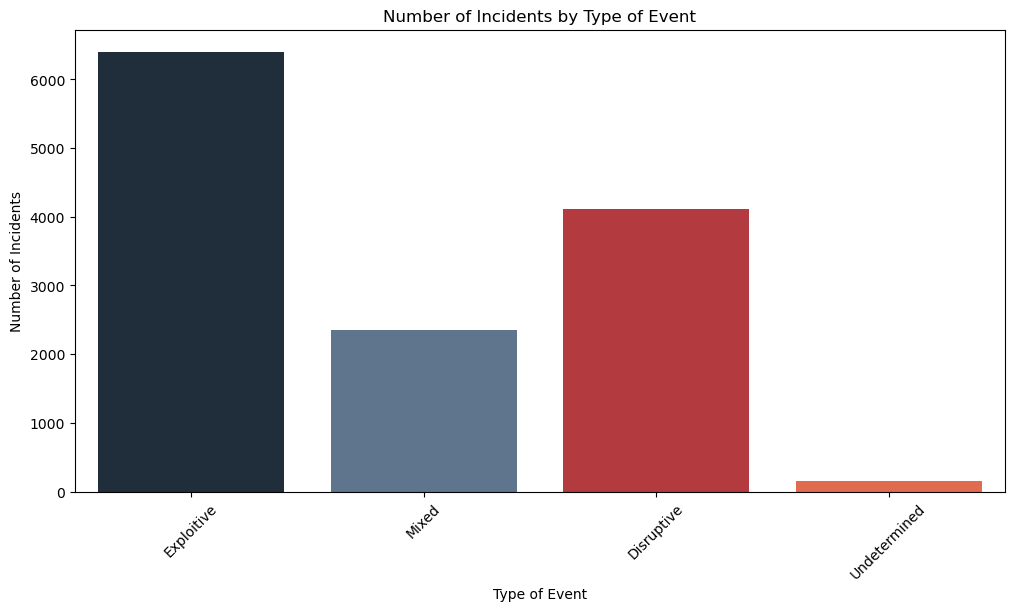

In [105]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_cleaned, x='event_type', palette=denexus_colors)
plt.title('Number of Incidents by Type of Event')
plt.xlabel('Type of Event')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid(False)
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "num-incidents-by-type-event.png")
    plt.savefig(output_path)
plt.show()

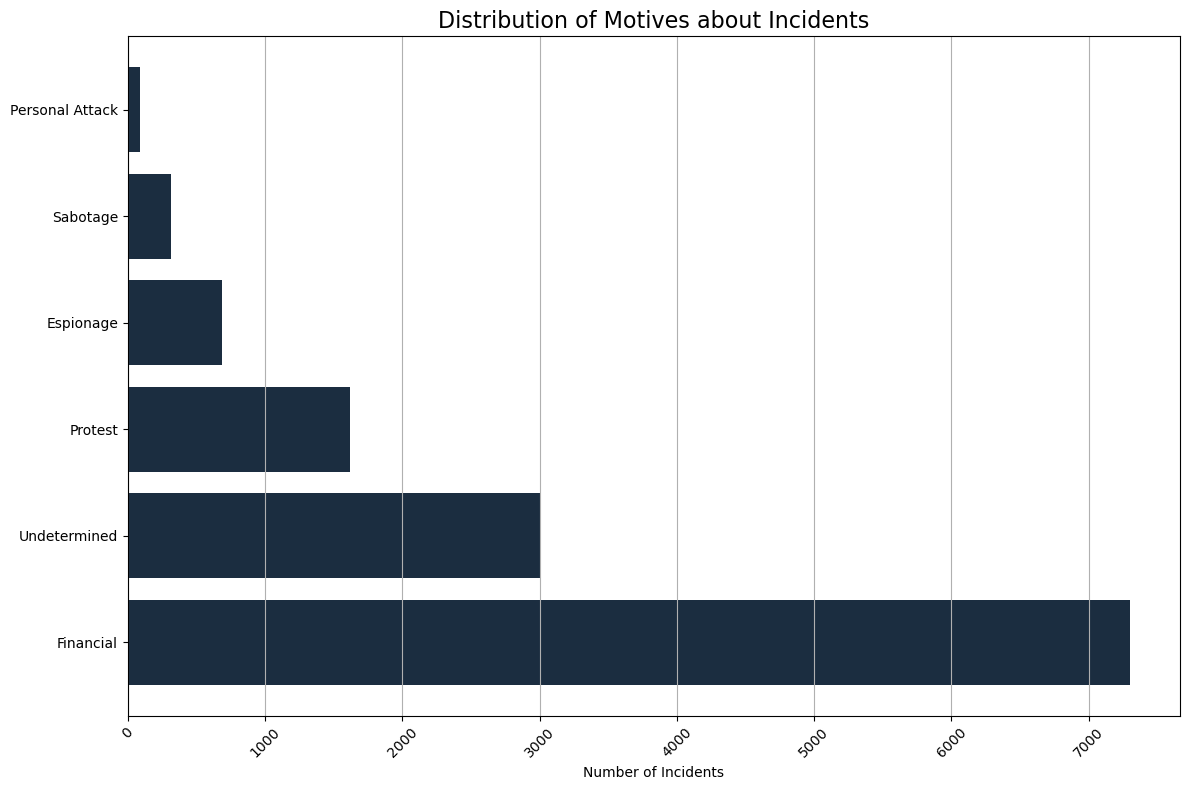

In [106]:
motive_counts = df_cleaned['motive'].value_counts()
labels = motive_counts.index
sizes = motive_counts.values

plt.figure(figsize=(12, 8))
plt.barh(labels, sizes, color=denexus_colors[0])
plt.xlabel('Number of Incidents')
plt.title('Distribution of Motives about Incidents', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='x')
plt.tight_layout()
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "distribution-motives-incidents.png")
    plt.savefig(output_path)
plt.show()

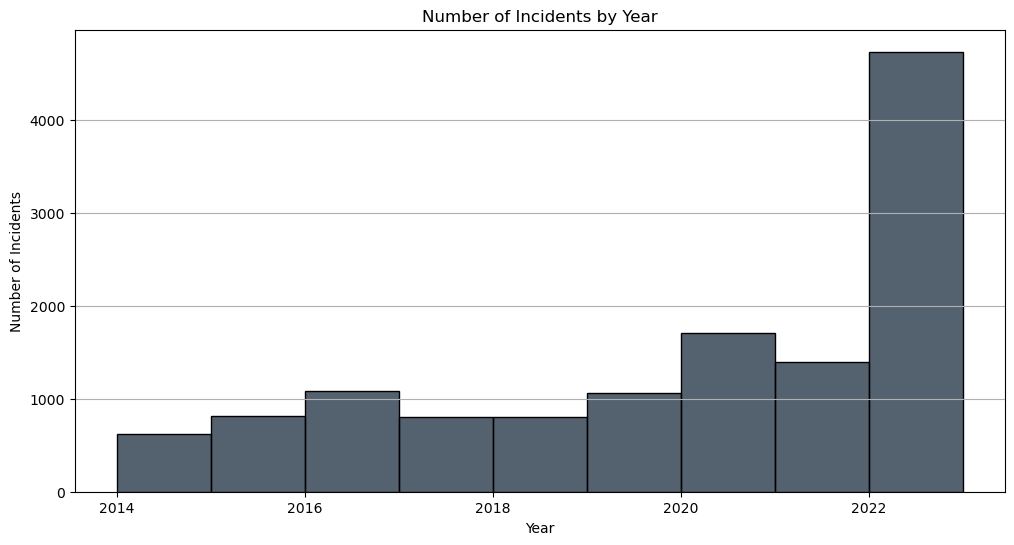

In [107]:
plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['year'], bins=range(df['year'].min(), df['year'].max() + 1), kde=False, color=denexus_colors[0])
plt.title('Number of Incidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(axis='y')
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "num-incidents-per-year.png")
    plt.savefig(output_path)
plt.show()